<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

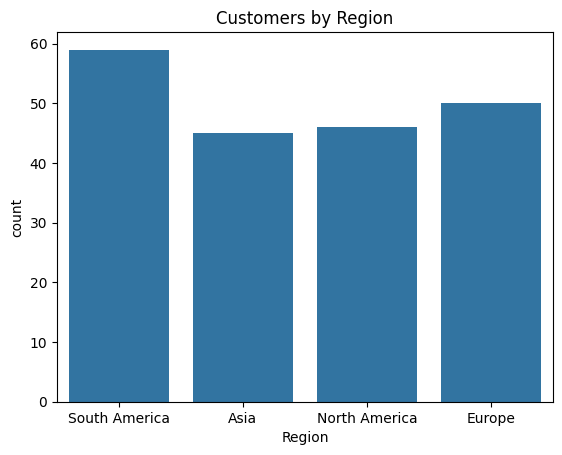

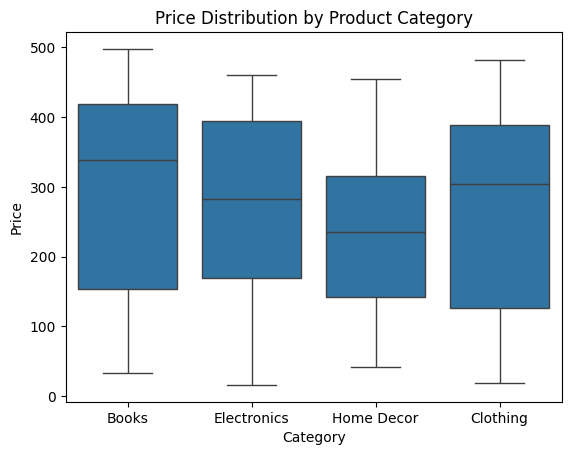

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

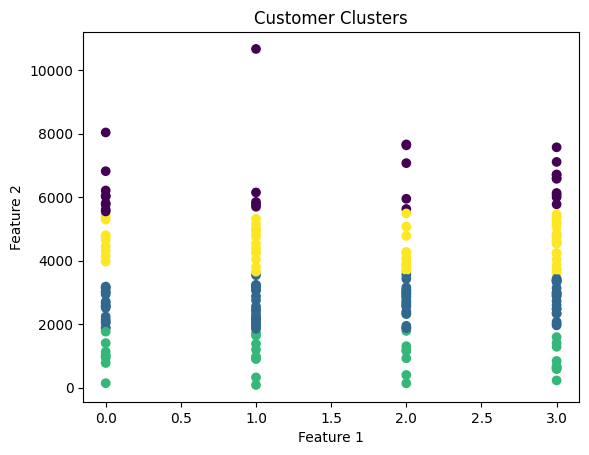

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


customers = pd.read_csv("/content/Customers.csv")
products = pd.read_csv("/content/Products.csv")
transactions = pd.read_csv("/content/Transactions.csv")



print(customers.info())
print(products.info())
print(transactions.info())


print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())


sns.countplot(x='Region', data=customers)
plt.title("Customers by Region")
plt.show()

sns.boxplot(x='Category', y='Price', data=products)
plt.title("Price Distribution by Product Category")
plt.show()


merged_data = pd.merge(transactions, customers, on="CustomerID")
merged_data = pd.merge(merged_data, products, on="ProductID")
print(merged_data.head())


top_products = merged_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(5)
print("Top 5 products by sales value:\n", top_products)

from sklearn.preprocessing import LabelEncoder

# Encode categorical columns in profile_data
label_encoder = LabelEncoder()
profile_data['Region'] = label_encoder.fit_transform(profile_data['Region'])

# Merge updated profile_data with transaction data
lookalike_data = pd.merge(profile_data, transaction_data, on="CustomerID").set_index("CustomerID")

# Scale numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(lookalike_data)


similarity_matrix = cosine_similarity(scaled_data)


recommendations = {}
for i, customer_id in enumerate(lookalike_data.index[:20]):
    similar_indices = similarity_matrix[i].argsort()[-4:-1][::-1]  # Top 3 similar customers
    recommendations[customer_id] = [(lookalike_data.index[j], similarity_matrix[i][j]) for j in similar_indices]


recommendations_df = pd.DataFrame([
    {"cust_id": customer, "similar_customers": rec[0], "score": rec[1]}
    for customer, rec_list in recommendations.items()
    for rec in rec_list
])
recommendations_df.to_csv("FirstName_LastName_Lookalike.csv", index=False)



segmentation_data = lookalike_data.copy()
kmeans = KMeans(n_clusters=4, random_state=42)  # Example with 4 clusters
clusters = kmeans.fit_predict(segmentation_data)


segmentation_data['Cluster'] = clusters


db_index = davies_bouldin_score(segmentation_data.drop(columns=['Cluster']), clusters)
print(f"Davies-Bouldin Index: {db_index}")


plt.scatter(segmentation_data.iloc[:, 0], segmentation_data.iloc[:, 1], c=clusters, cmap='viridis')
plt.title("Customer Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
